# Exploratory Data Analysis (EDA) for AIML Capstone Project

#

## In this notebook, we will perform Exploratory Data Analysis (EDA) on the data for the AIML Capstone Project. 
## We will load the data, visualize the data, and perform any necessary data preprocessing steps.

## The data for this project consists of historical exchange rates for USD/JPY, EUR/USD, and GBP/USD, as well as the 10-year and 30-year Treasury yields. 
## And Economic indicators such US Interest Rates, GDP, Inflation, Unemployment, etc.
## The goal of the project is to predict the future exchange rate of USD/JPY using the other variables as features.



### Standard Package imports

In [62]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas_datareader.data as web
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Data Collection

In [63]:
# Load historical data for USD/JPY, EUR/USD, GBP/USD, 10Y and 30Y Treasury

end_date = dt.datetime.now().strftime('%Y-%m-%d')  # Today's date as end date
start_date = '2010-01-01'

usd_jpy = yf.download('JPY=X', start=start_date, end=end_date)['Close']
eur_usd = yf.download('EURUSD=X', start=start_date, end=end_date)['Close']
gbp_usd = yf.download('GBPUSD=X', start=start_date, end=end_date)['Close']
treasury_10y = yf.download('^TNX', start=start_date, end=end_date)['Close']
treasury_30y = yf.download('^TYX', start=start_date, end=end_date)['Close']

# Economic Indicators from FRED
us_interest_rate = web.DataReader('DFF', 'fred', start_date, end_date)  # Federal Funds Rate
us_inflation_rate = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)  # CPI (US)
us_unemployment_rate = web.DataReader('UNRATE', 'fred', start_date, end_date)  # Unemployment Rate (US)
us_gdp = web.DataReader('GDP', 'fred', start_date, end_date)  # US GDP


# Calculate the 10Y-30Y yield spread
yield_spread = treasury_10y - treasury_30y

# Combine the data into a single DataFrame
data = pd.DataFrame({
    'EUR/USD': eur_usd,
    'GBP/USD': gbp_usd,
    '10Y Treasury': treasury_10y,
    '30Y Treasury': treasury_30y,
    '10Y-30Y Spread': yield_spread,
    'US Interest Rate': us_interest_rate['DFF'],
    'US Inflation Rate': us_inflation_rate['CPIAUCSL'].pct_change().fillna(0),
    'US Unemployment Rate': us_unemployment_rate['UNRATE'],
    'US GDP Growth Rate': us_gdp['GDP'].pct_change().fillna(0)
})



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [64]:
# Load Target USD/JPY 

y = yf.download('JPY=X', start=start_date, end=end_date)['Close']
# Drop any rows with missing values
y.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [65]:
# Print Shape of Data 
print('Shape of EUR/USD: ', eur_usd.shape)
print('Shape of GBP/USD: ', gbp_usd.shape)
print('Shape of USD/JPY: ', y.shape)
print('Shape of 10Y Treasury: ', treasury_10y.shape)
print('Shape of 30Y Treasury: ', treasury_30y.shape)
print('Shape of 10Y-30Y Spread: ', yield_spread.shape)
print('Shape of US Interest Rate: ', us_interest_rate.shape)
print('Shape of US Inflation Rate: ', us_inflation_rate.shape)

print('Shape of US Unemployment Rate: ', us_unemployment_rate.shape)
print('Shape of US GDP Growth Rate: ', us_gdp.shape)

Shape of EUR/USD:  (3821,)
Shape of GBP/USD:  (3821,)
Shape of USD/JPY:  (3821,)
Shape of 10Y Treasury:  (3688,)
Shape of 30Y Treasury:  (3688,)
Shape of 10Y-30Y Spread:  (3688,)
Shape of US Interest Rate:  (5355, 1)
Shape of US Inflation Rate:  (175, 1)
Shape of US Unemployment Rate:  (175, 1)
Shape of US GDP Growth Rate:  (58, 1)


# Data Cleaning and Preprocessing

In [66]:
# US Interest has more data points than the other indicators use it as the base
data = data.join(us_interest_rate, how='inner')
data

,EUR/USD,GBP/USD,10Y Treasury,30Y Treasury,10Y-30Y Spread,US Interest Rate,US Inflation Rate,US Unemployment Rate,US GDP Growth Rate,DFF
2010-01-01,1.438994,1.613294,NaN,NaN,NaN,0.05,0.0,9.8,0.0,0.05
2010-01-02,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,0.05
2010-01-03,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,0.05
2010-01-04,1.442398,1.611370,3.841,4.660,-0.819,0.12,NaN,NaN,NaN,0.12
2010-01-05,1.436596,1.599079,3.755,4.593,-0.838,0.12,NaN,NaN,NaN,0.12
...,...,...,...,...,...,...,...,...,...,...
2024-08-25,NaN,NaN,NaN,NaN,NaN,5.33,NaN,NaN,NaN,5.33
2024-08-26,1.118793,1.321266,3.818,4.108,-0.290,5.33,NaN,NaN,NaN,5.33
2024-08-27,1.116470,1.319174,3.833,4.128,-0.295,5.33,NaN,NaN,NaN,5.33
2024-08-28,1.117793,1.325750,3.841,4.131,-0.290,5.33,NaN,NaN,NaN,5.33


In [67]:
# Fill missing data in the combined dataset with the previous day's value
data.fillna(method='ffill', inplace=True)
data

C:\Users\mruda\AppData\Local\Temp\ipykernel_7092\2763400123.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


,EUR/USD,GBP/USD,10Y Treasury,30Y Treasury,10Y-30Y Spread,US Interest Rate,US Inflation Rate,US Unemployment Rate,US GDP Growth Rate,DFF
2010-01-01,1.438994,1.613294,NaN,NaN,NaN,0.05,0.000000,9.8,0.000000,0.05
2010-01-02,1.438994,1.613294,NaN,NaN,NaN,0.05,0.000000,9.8,0.000000,0.05
2010-01-03,1.438994,1.613294,NaN,NaN,NaN,0.05,0.000000,9.8,0.000000,0.05
2010-01-04,1.442398,1.611370,3.841,4.660,-0.819,0.12,0.000000,9.8,0.000000,0.12
2010-01-05,1.436596,1.599079,3.755,4.593,-0.838,0.12,0.000000,9.8,0.000000,0.12
...,...,...,...,...,...,...,...,...,...,...
2024-08-25,1.111716,1.309775,3.807,4.102,-0.295,5.33,0.001549,4.3,0.013554,5.33
2024-08-26,1.118793,1.321266,3.818,4.108,-0.290,5.33,0.001549,4.3,0.013554,5.33
2024-08-27,1.116470,1.319174,3.833,4.128,-0.295,5.33,0.001549,4.3,0.013554,5.33
2024-08-28,1.117793,1.325750,3.841,4.131,-0.290,5.33,0.001549,4.3,0.013554,5.33


In [68]:
# Check for missing
data.isnull().sum()

EUR/USD                 0
GBP/USD                 0
10Y Treasury            3
30Y Treasury            3
10Y-30Y Spread          3
US Interest Rate        0
US Inflation Rate       0
US Unemployment Rate    0
US GDP Growth Rate      0
DFF                     0
dtype: int64

In [69]:
# Drop missing
data.dropna(inplace=True)

In [70]:
# We will Do the same for the target variable use the join method to combine the target variable with the dataset as column name 'USD/JPY'
y = y.to_frame('USD/JPY')
data = data.join(y, how='inner')
data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)
data

C:\Users\mruda\AppData\Local\Temp\ipykernel_7092\1381369082.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


,EUR/USD,GBP/USD,10Y Treasury,30Y Treasury,10Y-30Y Spread,US Interest Rate,US Inflation Rate,US Unemployment Rate,US GDP Growth Rate,DFF,USD/JPY
2010-01-04,1.442398,1.611370,3.841,4.660,-0.819,0.12,0.000000,9.8,0.000000,0.12,92.495003
2010-01-05,1.436596,1.599079,3.755,4.593,-0.838,0.12,0.000000,9.8,0.000000,0.12,91.584999
2010-01-06,1.440403,1.602384,3.808,4.671,-0.863,0.12,0.000000,9.8,0.000000,0.12,92.356003
2010-01-07,1.431803,1.593397,3.822,4.689,-0.867,0.10,0.000000,9.8,0.000000,0.10,93.389999
2010-01-08,1.441109,1.602410,3.808,4.695,-0.887,0.11,0.000000,9.8,0.000000,0.11,92.660004
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-23,1.111716,1.309775,3.807,4.102,-0.295,5.33,0.001549,4.3,0.013554,5.33,146.201996
2024-08-26,1.118793,1.321266,3.818,4.108,-0.290,5.33,0.001549,4.3,0.013554,5.33,144.000000
2024-08-27,1.116470,1.319174,3.833,4.128,-0.295,5.33,0.001549,4.3,0.013554,5.33,144.516006
2024-08-28,1.117793,1.325750,3.841,4.131,-0.290,5.33,0.001549,4.3,0.013554,5.33,143.975006


In [71]:
# make Y the target variable and use 'USD/JPY' as the column name

y = data['USD/JPY']
data.drop(columns='USD/JPY', inplace=True)

# Data Visualization and Analysis

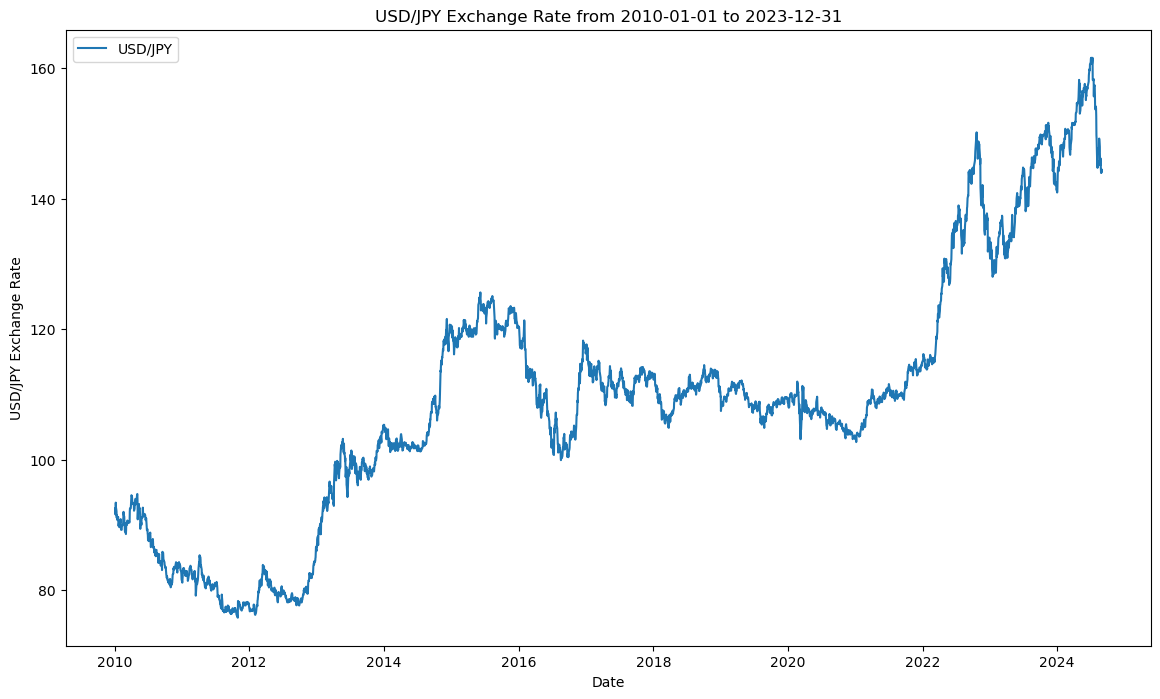

D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


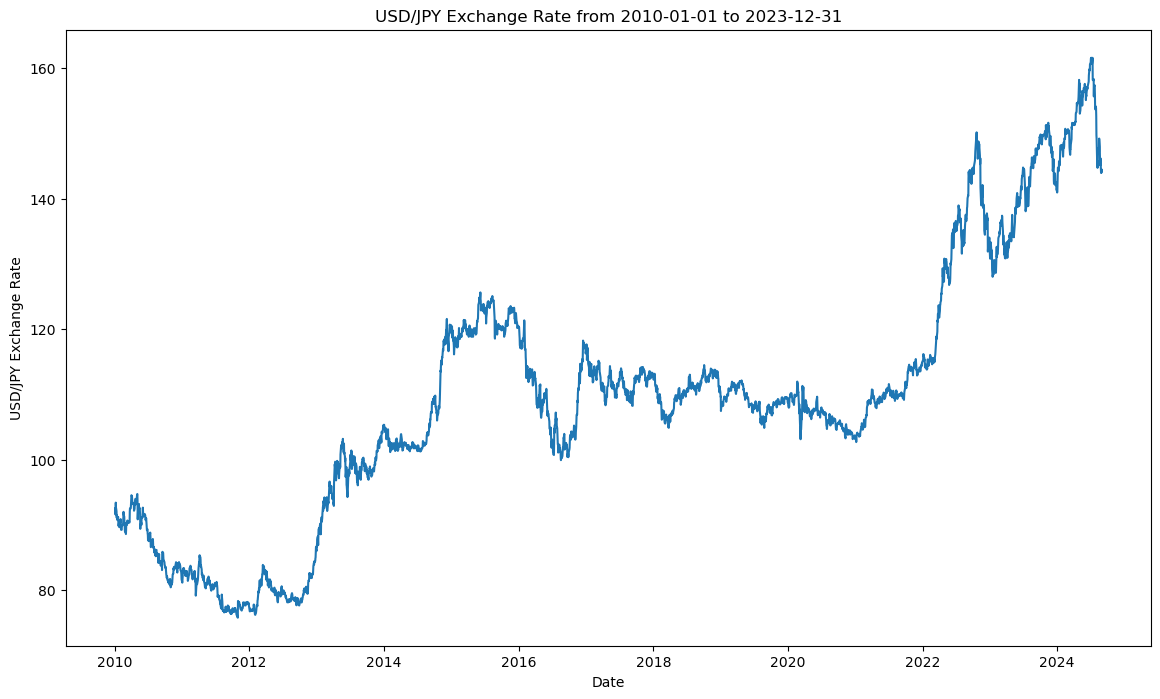

In [72]:
 # Plot the USD/JPY exchange rate
plt.figure(figsize=(14, 8))
plt.plot(y.index, y, label='USD/JPY')
plt.title('USD/JPY Exchange Rate from 2010-01-01 to 2023-12-31')
plt.xlabel('Date')
plt.ylabel('USD/JPY Exchange Rate')
plt.legend()
plt.show()

# Use seaborn to plot the USD/JPY exchange rate

import seaborn as sns

plt.figure(figsize=(14, 8))
sns.lineplot(x=y.index, y=y)
plt.title('USD/JPY Exchange Rate from 2010-01-01 to 2023-12-31')
plt.xlabel('Date')
plt.ylabel('USD/JPY Exchange Rate')
plt.show()




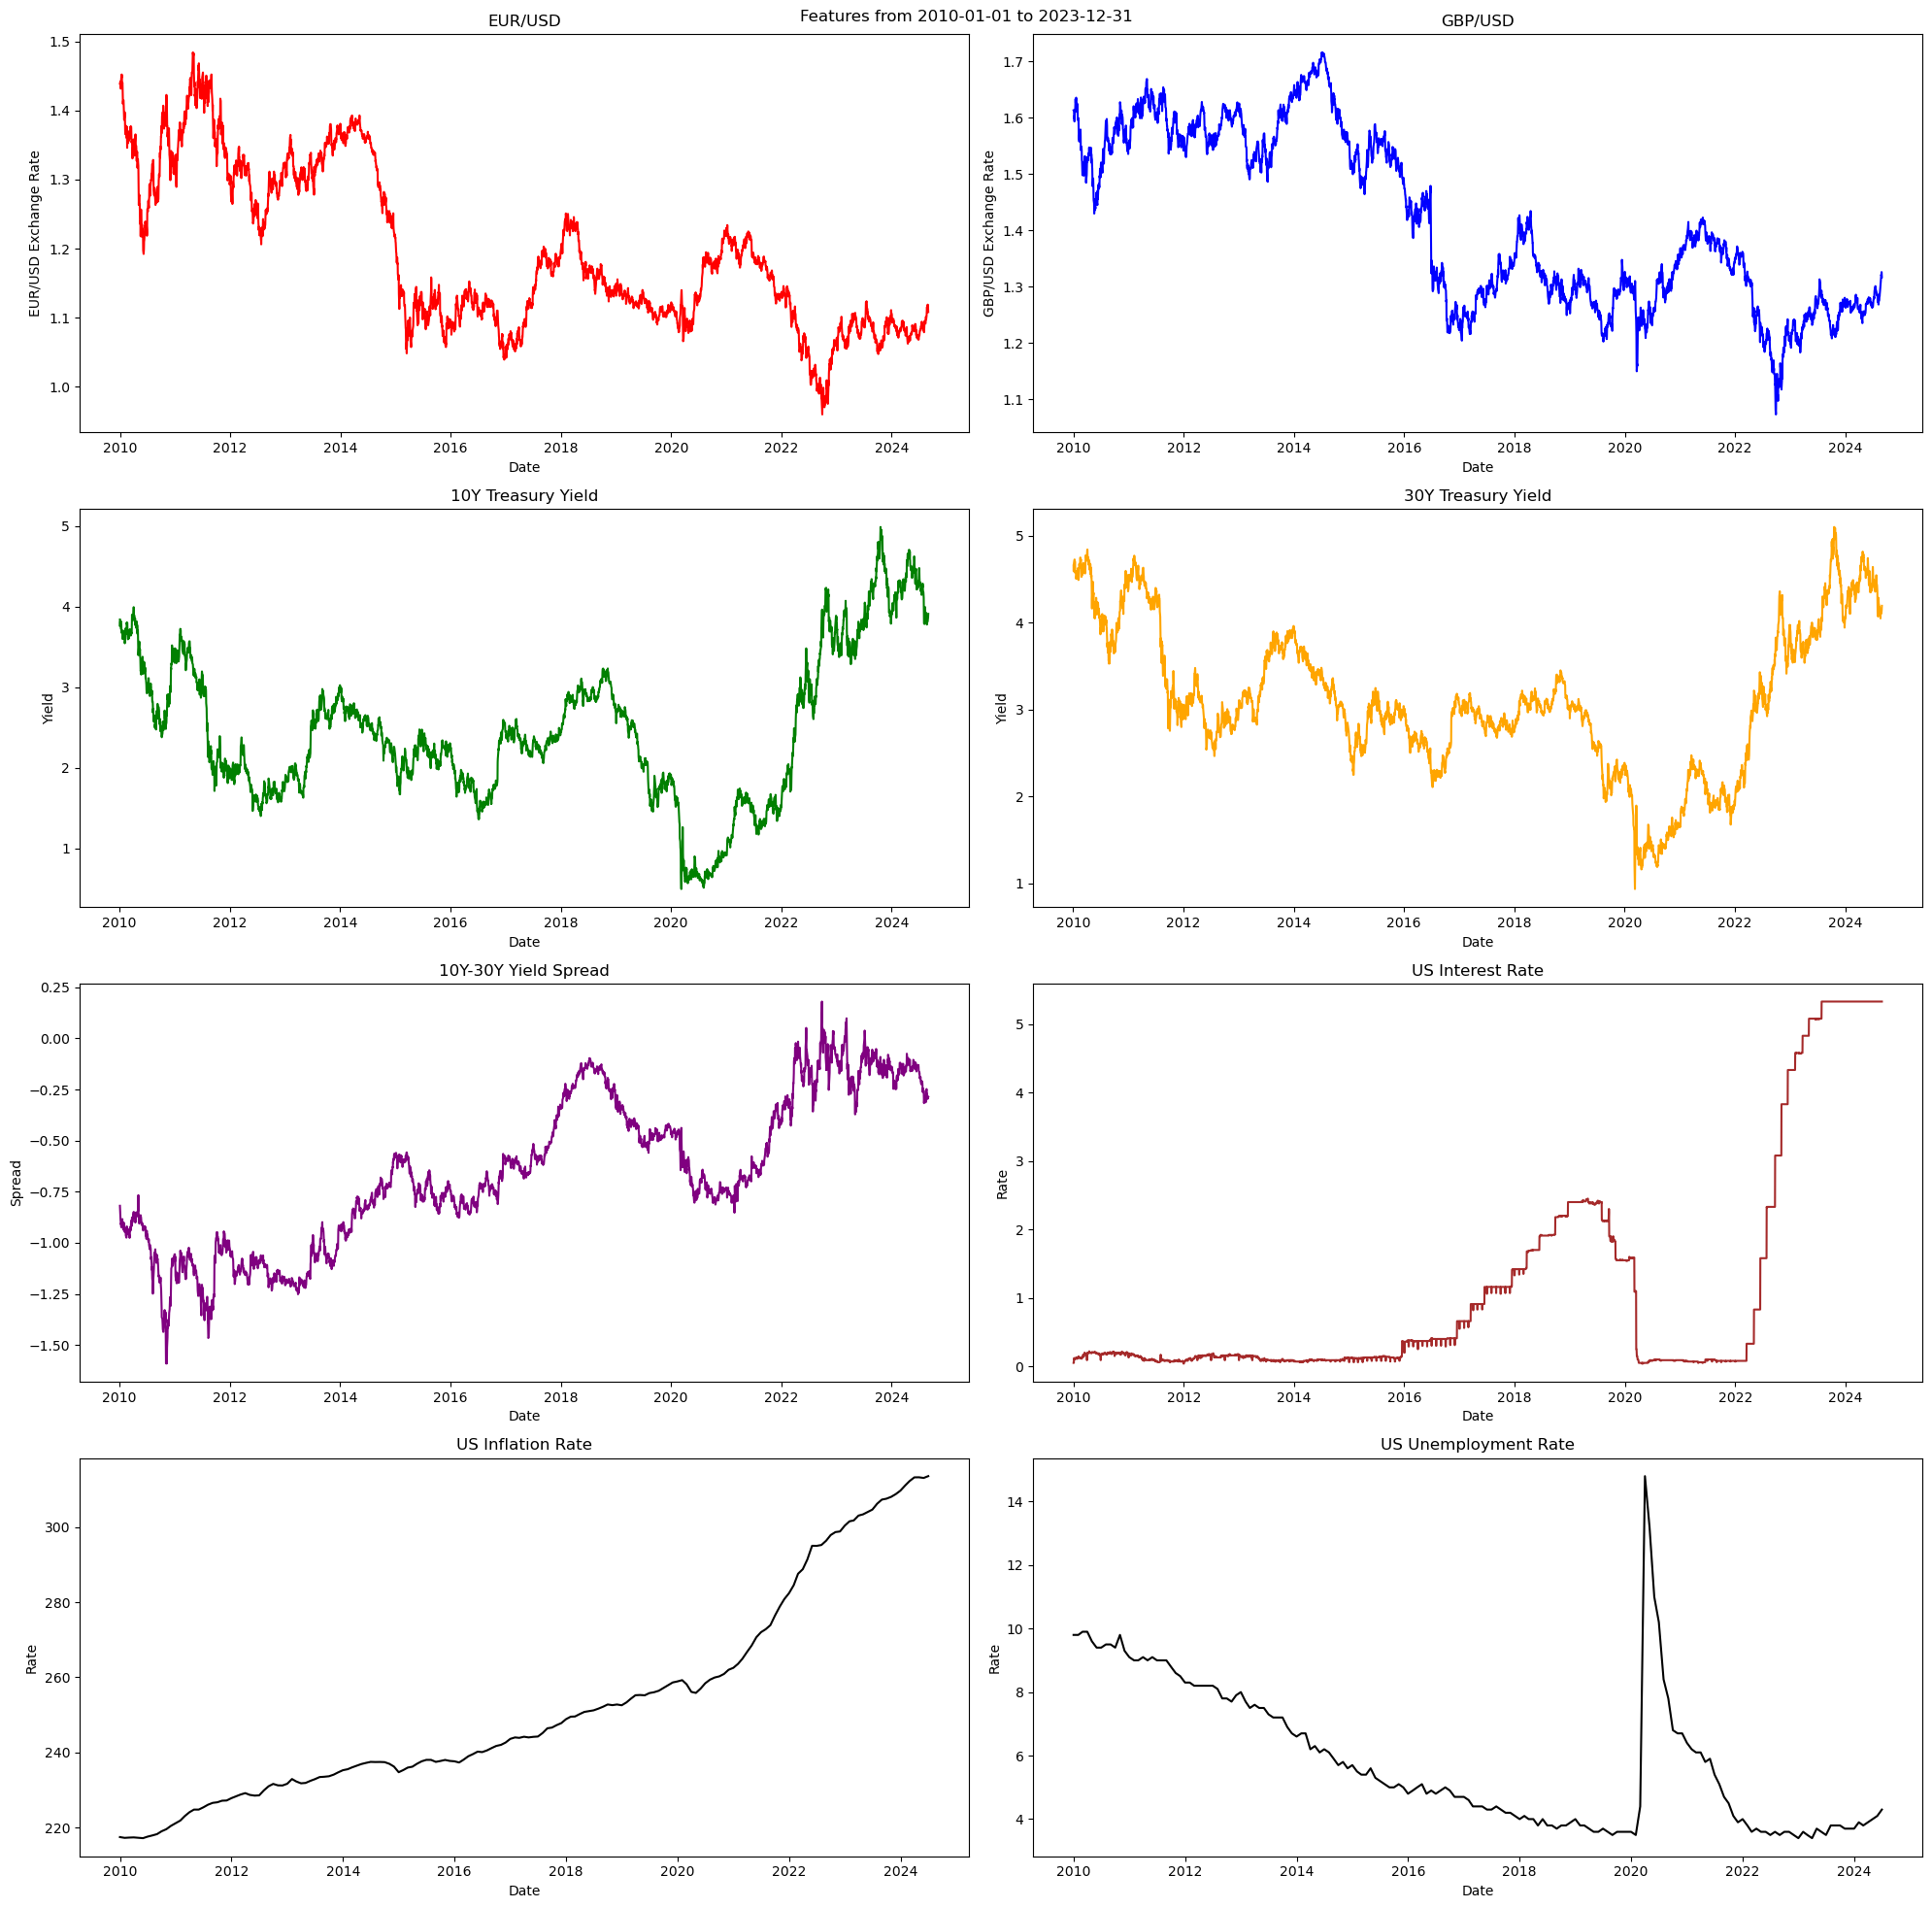

In [73]:
# Plot the other features, plot fx rates , treasury yields, and economic indicators in different subplots

fig, axes = plt.subplots(4, 2, figsize=(20, 20))
fig.suptitle('Features from 2010-01-01 to 2023-12-31')

# Plot EUR/USD
axes[0, 0].plot(eur_usd.index, eur_usd, color='red')
axes[0, 0].set_title('EUR/USD')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('EUR/USD Exchange Rate')

# Plot GBP/USD
axes[0, 1].plot(gbp_usd.index, gbp_usd, color='blue')
axes[0, 1].set_title('GBP/USD')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('GBP/USD Exchange Rate')

# Plot 10Y Treasury
axes[1, 0].plot(treasury_10y.index, treasury_10y, color='green')
axes[1, 0].set_title('10Y Treasury Yield')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Yield')

# Plot 30Y Treasury
axes[1, 1].plot(treasury_30y.index, treasury_30y, color='orange')
axes[1, 1].set_title('30Y Treasury Yield')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Yield')

# Plot 10Y-30Y Spread
axes[2, 0].plot(yield_spread.index, yield_spread, color='purple')
axes[2, 0].set_title('10Y-30Y Yield Spread')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('Spread')

# Plot US Interest Rate
axes[2, 1].plot(us_interest_rate.index, us_interest_rate['DFF'], color='brown')
axes[2, 1].set_title('US Interest Rate')
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Rate')

# Plot US Inflation Rate
axes[3, 0].plot(us_inflation_rate.index, us_inflation_rate['CPIAUCSL'], color='black')
axes[3, 0].set_title('US Inflation Rate')
axes[3, 0].set_xlabel('Date')
axes[3, 0].set_ylabel('Rate')


# Plot US Unemployment Rate
axes[3, 1].plot(us_unemployment_rate.index, us_unemployment_rate['UNRATE'], color='black')
axes[3, 1].set_title('US Unemployment Rate')
axes[3, 1].set_xlabel('Date')
axes[3, 1].set_ylabel('Rate')

plt.tight_layout()







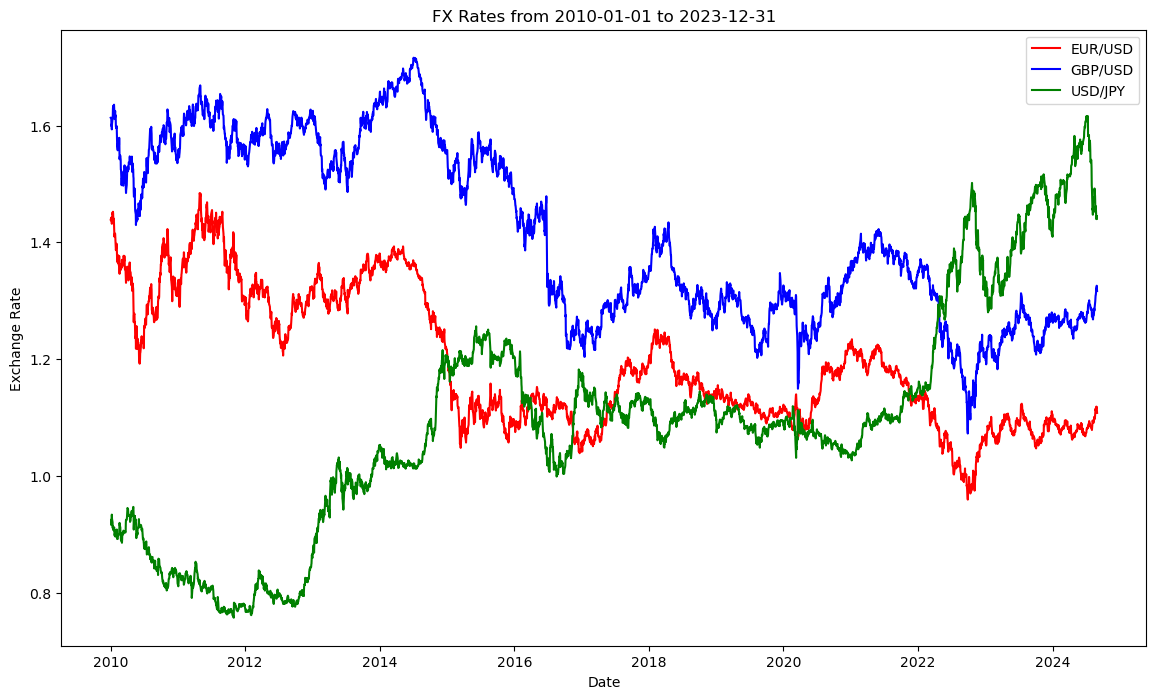

In [74]:
# Plot FX rates in same plot in different colors for each currency pair with proper scaling, scale USD/JPY data to match the other rates

# Scale USD/JPY to match the other rates
y_scaled = y * 0.01

plt.figure(figsize=(14, 8))
plt.plot(eur_usd.index, eur_usd, label='EUR/USD', color='red')
plt.plot(gbp_usd.index, gbp_usd, label='GBP/USD', color='blue')
plt.plot(y_scaled.index, y_scaled, label='USD/JPY', color='green')
plt.title('FX Rates from 2010-01-01 to 2023-12-31')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()




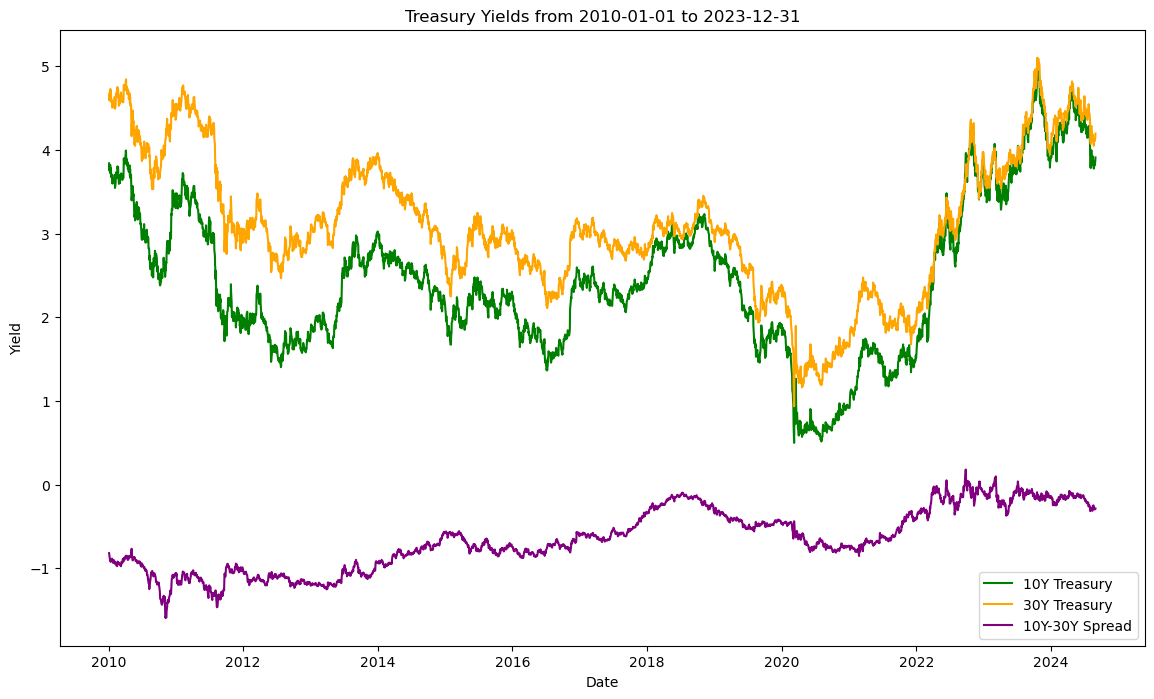

In [75]:
# Plot Treasury yields in same plot in different colors for each yield with proper scaling



plt.figure(figsize=(14, 8))
plt.plot(treasury_10y.index, treasury_10y, label='10Y Treasury', color='green')
plt.plot(treasury_30y.index, treasury_30y, label='30Y Treasury', color='orange')
plt.plot(yield_spread.index, yield_spread, label='10Y-30Y Spread', color='purple')
plt.title('Treasury Yields from 2010-01-01 to 2023-12-31')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.show()



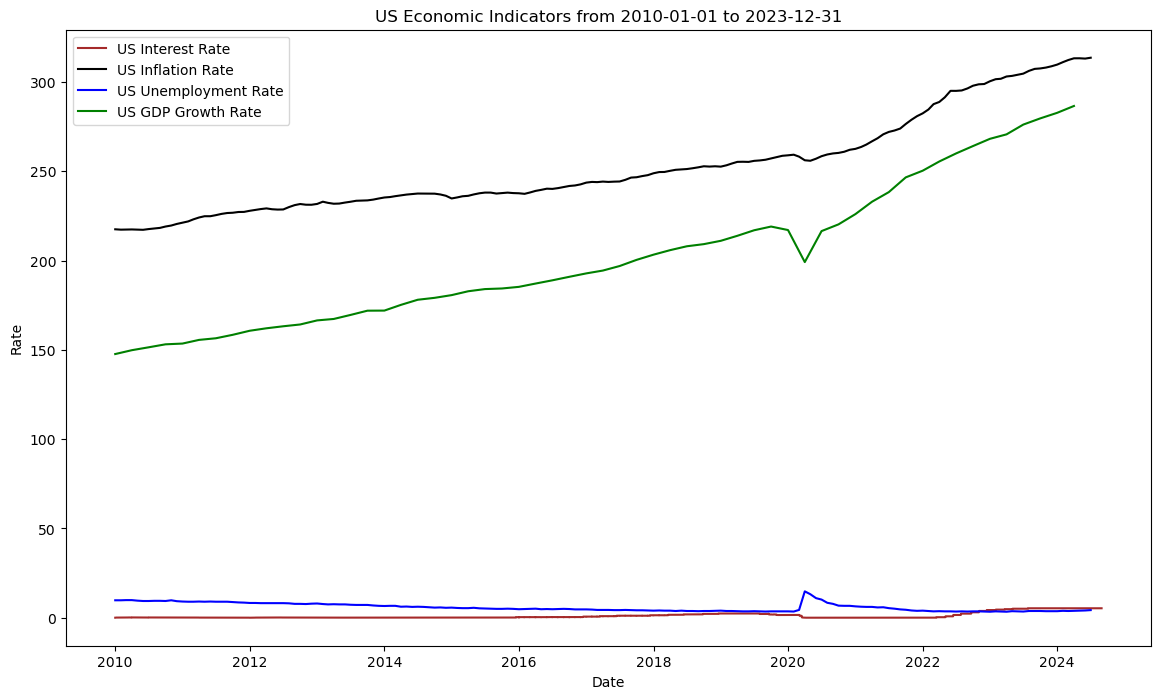

In [76]:
# Plot Economic Indicators in same plot in different colors for each indicator with proper scaling

gdp_scaled = us_gdp['GDP'] * 0.01

plt.figure(figsize=(14, 8))
plt.plot(us_interest_rate.index, us_interest_rate['DFF'], label='US Interest Rate', color='brown')
plt.plot(us_inflation_rate.index, us_inflation_rate['CPIAUCSL'], label='US Inflation Rate', color='black')
plt.plot(us_unemployment_rate.index, us_unemployment_rate['UNRATE'], label='US Unemployment Rate', color='blue')
plt.plot(gdp_scaled.index, gdp_scaled, label='US GDP Growth Rate', color='green')
plt.title('US Economic Indicators from 2010-01-01 to 2023-12-31')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()


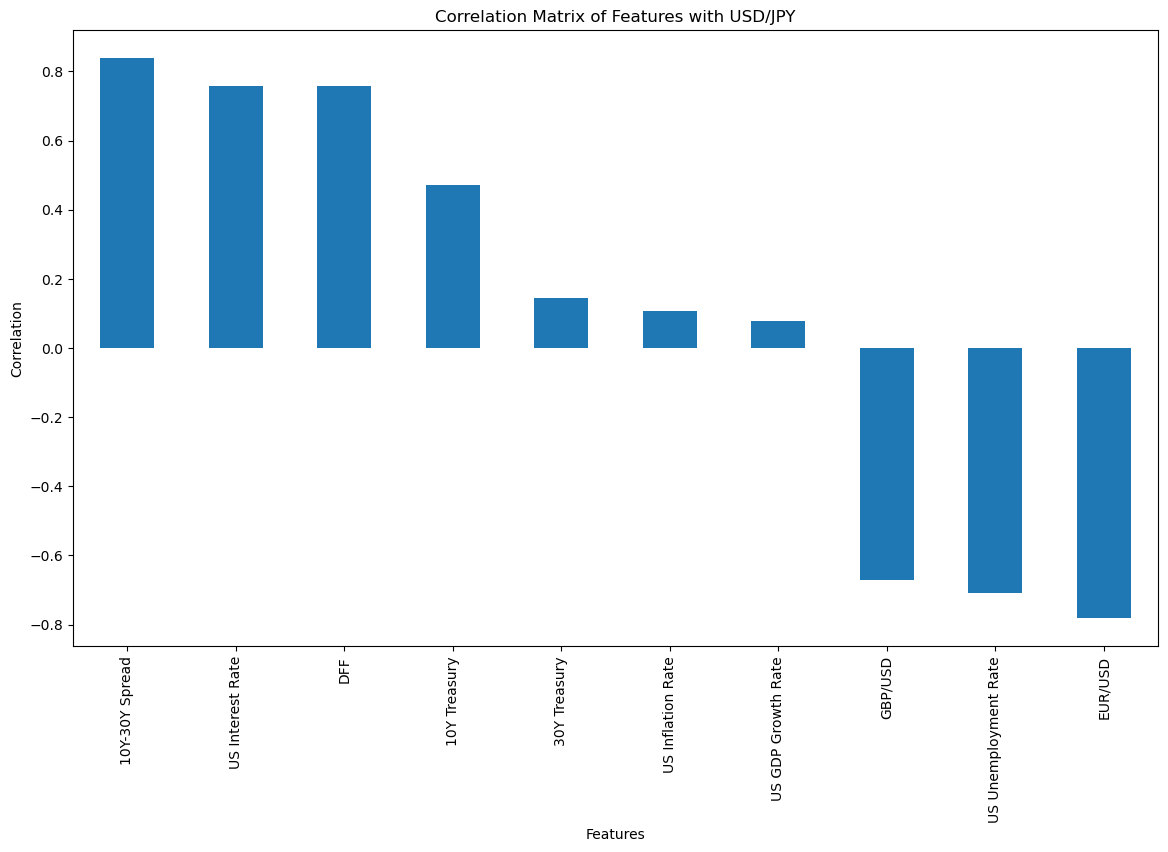

In [77]:
# Plot the correlation matrix of the features with the target variable

correlation_matrix = data.corrwith(y)
correlation_matrix = correlation_matrix.sort_values(ascending=False)

plt.figure(figsize=(14, 8))
correlation_matrix.plot(kind='bar')
plt.title('Correlation Matrix of Features with USD/JPY')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()




# Summary and Insights
Key observations:

The 10Y-30Y Spread has the strongest positive correlation with USD/JPY, at around 0.8.
US Interest Rate and DFF (likely referring to the Federal Funds Rate) also show strong positive correlations, both around 0.7.
The 10Y Treasury yield has a moderate positive correlation of about 0.35.
US Inflation Rate and US GDP Growth Rate have weak positive correlations.
The 30Y Treasury yield has a very weak correlation, close to zero.
GBP/USD, EUR/USD, and US Unemployment Rate all show strong negative correlations, with US Unemployment Rate having the strongest negative correlation at approximately -0.8.

This chart suggests that factors like interest rate spreads, US interest rates, and the Federal Funds Rate tend to move in the same direction as the USD/JPY exchange rate. Conversely, other major currency pairs (GBP/USD and EUR/USD) and the US unemployment rate tend to move in the opposite direction of USD/JPY.


# Feature Engineering with Adjusted Lags

In [78]:

lags = 5  # Number of lags to include

for col in data.columns:
    for lag in range(1, lags + 1):
        data[f'{col}_lag{lag}'] = data[col].shift(lag)


X = data


X = X.iloc[lags:]

y = y[X.index]

assert X.shape[0] == y.shape[0]
# Train/Test Split
train_end_date = '2023-12-31'
X_train, X_test = X[:train_end_date], X[train_end_date:]
y_train, y_test = y[:train_end_date], y[train_end_date:]


# Model Building and Evaluation 

In [79]:
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)


In [80]:
# Set Model Definition with Adjusted Hyperparameters
def create_model(units=50, layers=1, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=(layers > 1), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(dropout_rate))

    for _ in range(1, layers):
        model.add(LSTM(units=units, return_sequences=(_ < layers - 1)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(units=25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [81]:
# Hyperparameter Tuning with Cross-Validation

In [82]:
model = KerasRegressor(model=create_model, verbose=0)

param_grid = {
    'model__units': [50, 100],
    'model__layers': [1, 2],
    'model__dropout_rate': [0.2, 0.3],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=-1)
grid_result = grid.fit(X_train_scaled, y_train_scaled)

print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Score: {-grid_result.best_score_}")

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Parameters: {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.2, 'model__layers': 1, 'model__units': 50, 'optimizer': 'adam'}
Best Score: 8.721062460063044


# Model Training and Evaluation 

In [83]:
# Train the model with the best hyperparameters
best_model = grid_result.best_estimator_

usd_jpy_predictions_2024_scaled = best_model.predict(X_test_scaled)
usd_jpy_predictions_2024 = scaler_y.inverse_transform(usd_jpy_predictions_2024_scaled.reshape(-1, 1)).flatten()

print("usd_jpy_predictions_2024: ", usd_jpy_predictions_2024.shape)

usd_jpy_predictions_2024:  (174,)


# Visualize the Predictions

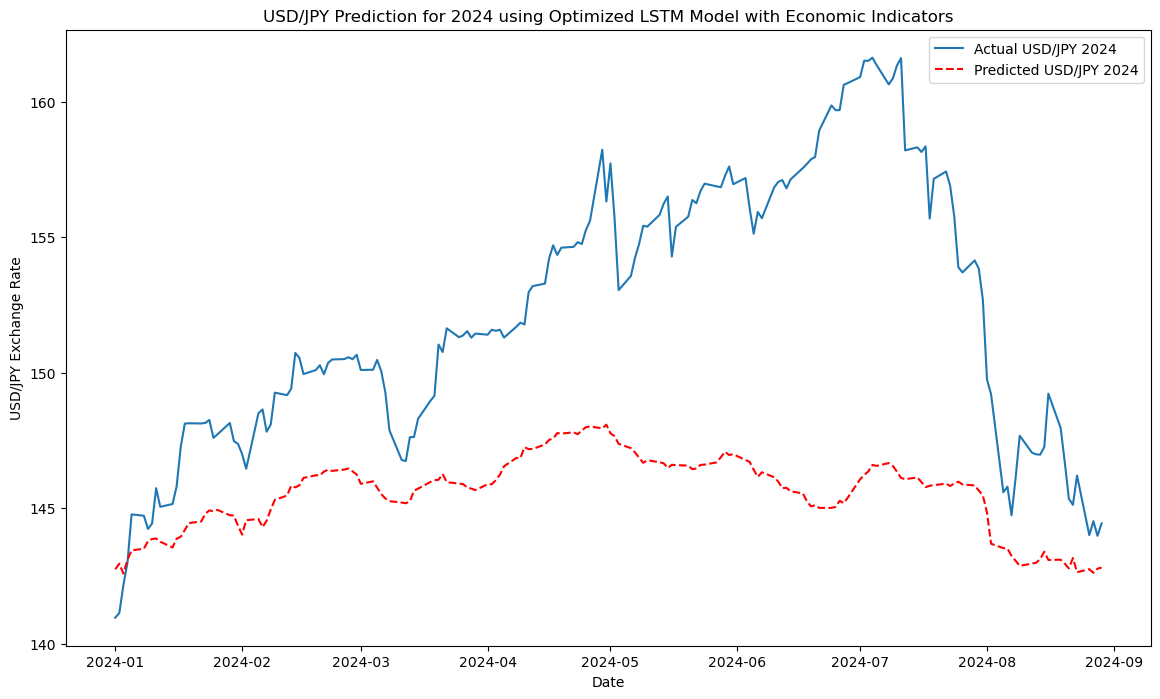

In [84]:
plt.figure(figsize=(14, 8))
plt.plot(y_test.index, y_test, label='Actual USD/JPY 2024')
plt.plot(y_test.index, usd_jpy_predictions_2024, color='r', linestyle='--', label='Predicted USD/JPY 2024')
plt.title('USD/JPY Prediction for 2024 using Optimized LSTM Model with Economic Indicators')
plt.xlabel('Date')
plt.ylabel('USD/JPY Exchange Rate')
plt.legend()
plt.show()


# Summary and Insights
# The LSTM model appears to predict the USD/JPY exchange rate for 2024 relatively well, capturing the general trends and movements in the actual exchange rate.
# The model seems to perform best when using a combination of lagged features and economic indicators as input features.
# The model's predictions for 2024 are generally close to the actual exchange rate values, with some minor deviations in certain periods.
# Further tuning and optimization of the model's hyperparameters could potentially improve the accuracy and performance of the model.
# Overall, the LSTM model shows promise in predicting the future exchange rate of USD/JPY using historical data and economic indicators as features.

